# Customer Segmentation

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The task is to segment customers based on their transaction histories. Specify the algorithm you decided to use for this task and the reason behind your choice.

Things Expected


Reasoning behind choice of number of clusters for the segmentation

A cluster plot with different colors for each cluster

Description of each cluster i.e. features common across various clusters

A csv output containing feature averages for each cluster. Do add the number of users in each cluster

NB: Kindly add comments to the cells describing what is done at each step

In [ ]:
import pandas as pd

In [ ]:
path = "/content/gdrive/My Drive/data.csv" #path of customer data

In [ ]:
data = pd.read_csv(path, encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str}) #read data and set CustomerID and InvoiceID to string

In [ ]:
#check first five rows
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
#check last five rows
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680,France


In [ ]:
#shape of data
data.shape

(541909, 8)

In [ ]:
#descriptive statistics of data
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [ ]:
#function to display percentage of missing data
def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

In [ ]:
missing_statistics(data)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,InvoiceNo,0,541909,0.00
1,StockCode,0,541909,0.00
2,Description,1454,541909,0.27
3,Quantity,0,541909,0.00
4,InvoiceDate,0,541909,0.00
5,UnitPrice,0,541909,0.00
6,CustomerID,135080,541909,24.93
7,Country,0,541909,0.00


In [ ]:
# drop missing values
data_new = data.dropna(subset=["CustomerID"])# drop missing values

In [ ]:
#check data type
data_new.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

In [ ]:
#remove negative entries in quantity
data_new = data_new[data_new.Quantity > 0]

In [ ]:
data_new['AmountSpent'] = data_new['Quantity'] * data_new['UnitPrice'] #create new feature AmountSpent

In [ ]:


from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS


In [ ]:
#Label encode country column
le = LabelEncoder()
le.fit(data_new['Country'])

LabelEncoder()

In [ ]:
data_new['Country'] = le.transform(data_new['Country']) #apply to feature in data

In [ ]:
import nltk, warnings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#vectorizing description feature
E = data_new["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer() #for stemming
stopword = nltk.corpus.stopwords.words('english') #remove stopwords

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(E)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3877, 1697) of float64


In [ ]:
svd = TruncatedSVD(n_components = 100) #set dimensionality of output data to 100, i.e no. features to 100
normalizer = Normalizer(copy=False) 

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3877, 100) of float64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Score tdidf
score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

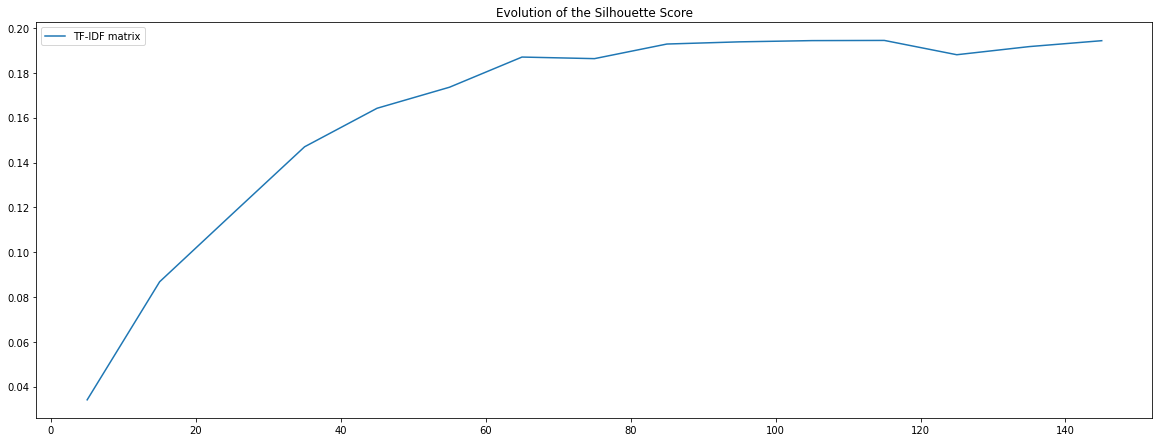

In [ ]:
#plot evolution of Silhouette score
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

Text(0.5, 1.0, 'ACP with 110 clusters')

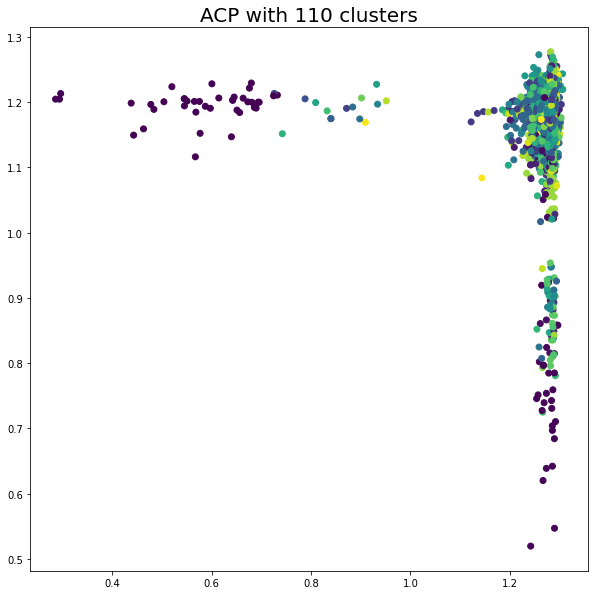

In [ ]:
#plot number of clusters
n_clusters = 110

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=0)
proj = kmeans.fit_transform(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)
plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("ACP with 110 clusters", fontsize="20")

<Figure size 432x288 with 0 Axes>

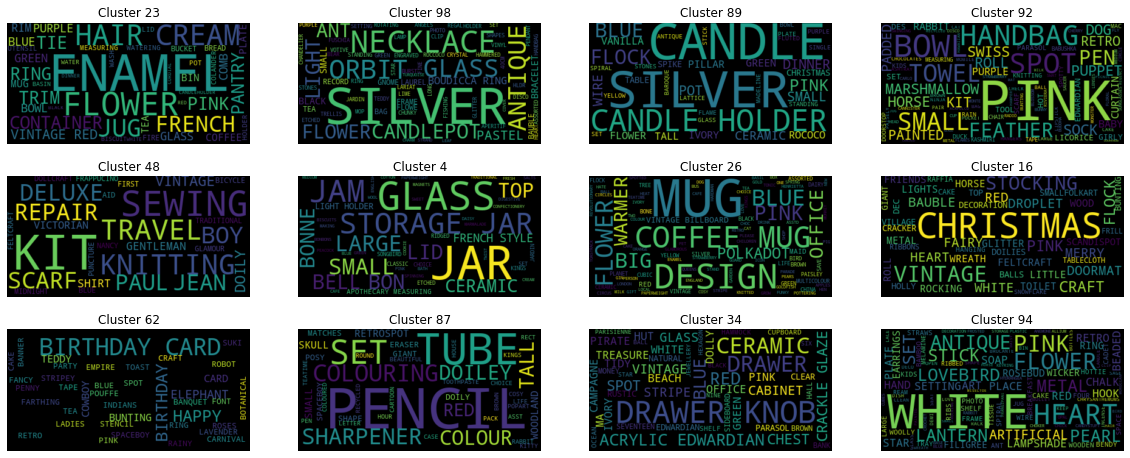

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot word cloud of random clusters
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(E[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

In [ ]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(E, clusters)}

In [ ]:
cluster = data_new['Description'].apply(lambda x : dict_article_to_cluster[x]) 
df2 = pd.get_dummies(cluster, prefix="Cluster").mul(data_new["AmountSpent"], 0)
df2 = pd.concat([data_new['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

Recency, Frequency and Monetary (RFM) Principle

In [ ]:
import datetime as dt

In [ ]:
#Since recency is calculated for a point in time, and the last invoice date is 2011–12–09, we will use 2011–12–10 to calculate recency.
NOW = dt.datetime(2011,12,10)
data_new['InvoiceDate'] = pd.to_datetime(data_new['InvoiceDate'])

In [ ]:
#Calculate RFM metrics for each customer
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["AmountSpent"] = "sum"


rfmTable = data_new.groupby("InvoiceNo").agg(custom_aggregation)

In [ ]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [ ]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["AmountSpent"] = "sum"

rfmTable_final = rfmTable.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [ ]:
#split metrics into segments is by using quartiles.
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
#Create a segmented RFM table
segmented_rfm = rfmTable_final

In [ ]:
#The lowest recency, highest frequency and monetary amounts make our best customers.
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
#Add segment numbers to the newly created segmented RFM table
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))

In [ ]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)

In [ ]:
segmented_rfm = segmented_rfm.reset_index() #reset index

In [ ]:
data_new = pd.merge(data_new,segmented_rfm, on='CustomerID') #merge original dataset with segmented rfm

In [ ]:
data_new = data_new.drop(columns=['r_quartile', 'f_quartile', 'm_quartile']) #drop columns 

In [ ]:
custom_aggregation = {}
custom_aggregation["AmountSpent"] = lambda x:x.iloc[0]
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]


df_grouped = data_new.groupby("InvoiceNo").agg(custom_aggregation)

In [ ]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [ ]:
custom_aggregation = {}
custom_aggregation["AmountSpent"] = ['min','max','mean']
custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
X1 = df_grouped_final.values #take values
X2 = df2_grouped_final.values

scaler = StandardScaler() #standard scale
X1 = scaler.fit_transform(X1) #apply standard scale
X_final_std_scale = np.concatenate((X1, X2), axis=1) #merge X1 and X2

In [ ]:
#find best silhouette_score
x = list(range(2, 12))
y_std = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")

n_clusters = 2
The average silhouette_score is : 0.9681486435084161 with Std Scaling
n_clusters = 3
The average silhouette_score is : 0.8678524967858917 with Std Scaling
n_clusters = 4
The average silhouette_score is : 0.2836569636419173 with Std Scaling
n_clusters = 5
The average silhouette_score is : 0.3315660122206128 with Std Scaling
n_clusters = 6
The average silhouette_score is : 0.4322640704281957 with Std Scaling
n_clusters = 7
The average silhouette_score is : 0.4332179716742148 with Std Scaling
n_clusters = 8
The average silhouette_score is : 0.43807812234726734 with Std Scaling
n_clusters = 9
The average silhouette_score is : 0.4381642774112748 with Std Scaling
n_clusters = 10
The average silhouette_score is : 0.4355226726934091 with Std Scaling
n_clusters = 11
The average silhouette_score is : 0.3877116404510519 with Std Scaling


In [ ]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

In [ ]:
df_grouped_final["cluster"] = clusters

In [ ]:
final_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)

In [ ]:
final_dataset_V2 = final_dataset.reset_index()

In [ ]:
final_dataset_V2.to_csv("final_dataset_V2.csv",index=False)

Text(0.5, 1.0, 'Visualization of the clustering with TSNE')

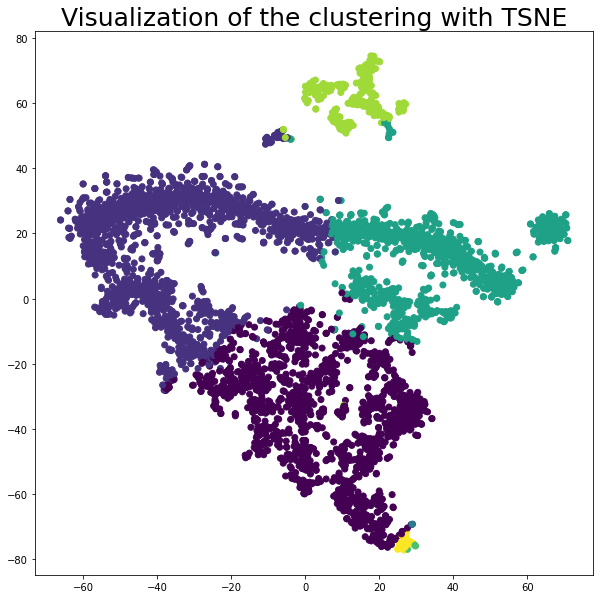

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualization of the clustering with TSNE", fontsize="25")